In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Conv1D, Add, Flatten, Dropout, Dense, BatchNormalization, Activation
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:

# Load the data
df = pd.read_csv(r'C:\Users\ASUS\Documents\Zalo Received Files\HaNoi.csv')
print(df.columns)

# Preprocess the data
df['date'] = pd.to_datetime(df['date'], dayfirst=True)  # Chuyển đổi cột date thành định dạng thời gian
df.set_index('date', inplace=True)  # Đặt cột date làm index


# Check for null values and drop them
null_count = df.isnull().sum()
print(null_count)
df = df.dropna()

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['AQI']])

# Prepare data function
def prepare_data(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

timesteps = 30  # Độ dài của cửa sổ trượt
X, y = prepare_data(scaled_data, timesteps)




Index(['Index', 'date', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'AQI'], dtype='object')
Index    0
pm25     0
pm10     0
o3       0
no2      0
so2      0
co       0
AQI      0
dtype: int64


In [3]:

# Build the model
input_layer = Input(shape=(timesteps, 1))
# x = LSTM(64, return_sequences=True)(input_layer)
x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(input_layer)
x = Conv1D(64, kernel_size=2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=1, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv1D(1, kernel_size=3, padding='same')(x)
x = Add()([x, input_layer])
output_layer = Activation('tanh')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 30, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 30, 64)            │             256 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 30, 64)            │           8,256 │ conv1d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 30, 64)            │             256 │ conv1d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, 30, 64)            │           4,160 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 30, 64)            │             256 │ conv1d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_3 (Conv1D)             │ (None, 30, 64)            │          12,352 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 30, 64)            │             256 │ conv1d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_4 (Conv1D)             │ (None, 30, 1)             │             193 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 30, 1)             │               0 │ conv1d_4[0][0],            │
│                               │                           │                 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 30, 1)             │               0 │ add[0][0]                  │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 25,985 (101.50 KB)

 Trainable params: 25,601 (100.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [4]:
def predict_future(model, data, time_step, future_days, scaler):
    temp_input = data[-time_step:].reshape(1, time_step, 1)
    future_output = []

    for _ in range(future_days):
        prediction = model.predict(temp_input, verbose=0)
        future_output.append(prediction[0][0])
        temp_input = np.roll(temp_input, -1)  # Dịch chuyển các phần tử sang trái 1 vị trí
        temp_input[-1][-1] = prediction[0][0]  # Gán giá trị dự đoán vào vị trí cuối cùng của temp_input

    future_output = scaler.inverse_transform(np.array(future_output).reshape(-1, 1))
    return future_output


def custom_round(number):
    if number >= 0:
        return int(number + 0.5)  # Làm tròn lên
    else:
        return int(number - 0.5)  # Làm tròn xuống
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


[[0.31622177]
 [0.1889117 ]
 [0.20123203]
 ...
 [0.03696099]
 [0.0349076 ]
 [0.02874743]]
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1573 - mae: 0.2956 - val_loss: 0.0146 - val_mae: 0.0972
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0184 - mae: 0.1025 - val_loss: 0.0169 - val_mae: 0.1041
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0147 - mae: 0.0870 - val_loss: 0.0166 - val_mae: 0.1023
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0102 - mae: 0.0764 - val_loss: 0.0123 - val_mae: 0.0849
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091 - mae: 0.0717 - val_loss: 0.0138 - val_mae: 0.0916
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - mae: 0.0697 - val_loss: 0.0116 - val_mae: 0.0823
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - mae: 0.0662 - val_loss: 0.0097 - val_mae: 0.0704
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - mae: 0.0662 - val_loss: 0.0099 

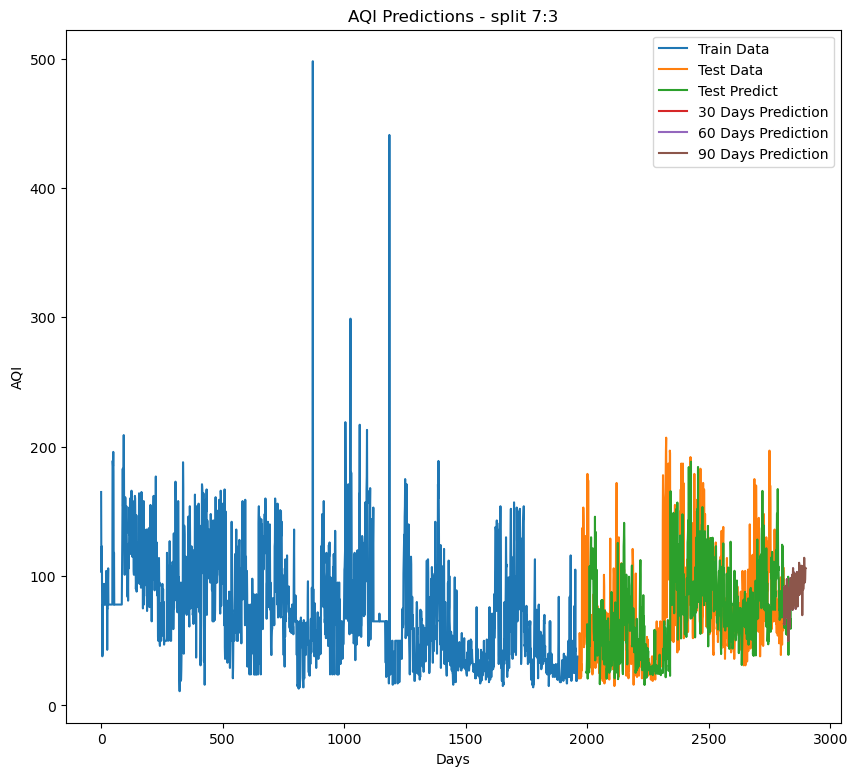

[[0.31622177]
 [0.1889117 ]
 [0.20123203]
 ...
 [0.04517454]
 [0.0862423 ]
 [0.0349076 ]]
Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - mae: 0.0539 - val_loss: 0.0072 - val_mae: 0.0625
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - mae: 0.0569 - val_loss: 0.0065 - val_mae: 0.0625
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - mae: 0.0566 - val_loss: 0.0065 - val_mae: 0.0648
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - mae: 0.0569 - val_loss: 0.0077 - val_mae: 0.0632
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - mae: 0.0557 - val_loss: 0.0082 - val_mae: 0.0666
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - mae: 0.0555 - val_loss: 0.0068 - val_mae: 0.0638
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - mae: 0.0551 - val_loss: 0.0072 - val_mae: 0.0614
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - mae: 0.0552 - val_loss: 0.0062 

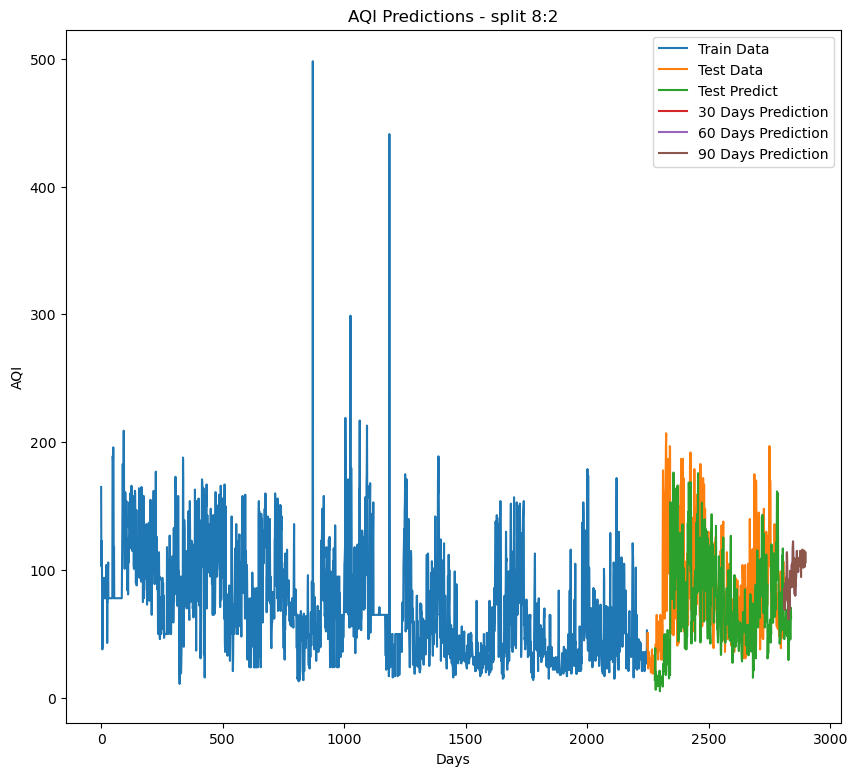

[[0.31622177]
 [0.1889117 ]
 [0.20123203]
 ...
 [0.18685832]
 [0.1211499 ]
 [0.19096509]]
Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - mae: 0.0581 - val_loss: 0.0040 - val_mae: 0.0483
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - mae: 0.0544 - val_loss: 0.0048 - val_mae: 0.0516
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - mae: 0.0556 - val_loss: 0.0067 - val_mae: 0.0644
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - mae: 0.0542 - val_loss: 0.0049 - val_mae: 0.0525
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058 - mae: 0.0566 - val_loss: 0.0050 - val_mae: 0.0574
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058 - mae: 0.0572 - val_loss: 0.0044 - val_mae: 0.0545
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - mae: 0.0553 - val_loss: 0.0047 - val_mae: 0.0568
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - mae: 0.0541 - val_loss: 0.0036 

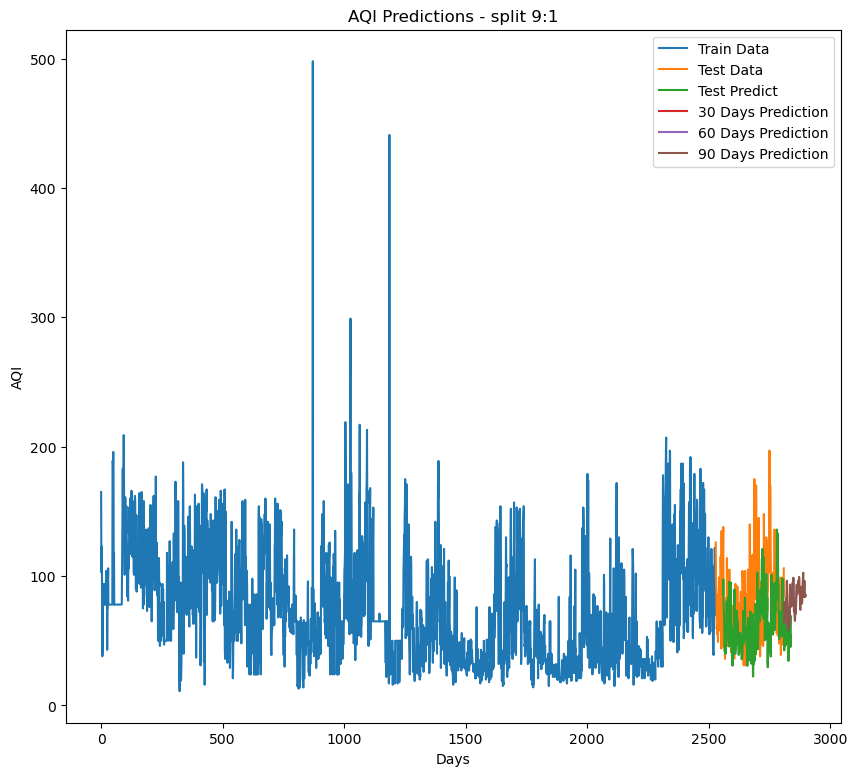

In [5]:
train_sizes = [0.7, 0.8, 0.9]
for train_size_ratio in train_sizes:
    # Split data into training and testing sets
    train_size = int(len(X) * train_size_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    # Reshape data to match model input
    X_train = np.reshape(X_train, (X_train.shape[0], timesteps, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], timesteps, 1))
    print(y_train)
    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
    
    # Predict on test data
    y_pred = model.predict(X_test)
    
    # Inverse transform the predictions and true values
    y_pred_inverse = scaler.inverse_transform(y_pred[:, -1, 0].reshape(-1, 1))
    y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_train_inverse = scaler.inverse_transform(y_train.reshape(-1, 1))
    
      # Calculate error metrics
    rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
    mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
    mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)
    
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape}%')  
       # Calculate future predictions
    df1 = df.reset_index()['AQI']
    scaler = MinMaxScaler(feature_range=(0, 1))
    df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))
    future_30_days = predict_future(model, df1, timesteps, 30, scaler)
    future_60_days = predict_future(model, df1, timesteps, 60, scaler)
    future_90_days = predict_future(model, df1, timesteps, 90, scaler)
    # Plot the results
    plt.figure(figsize=(10, 9))

    # Plot train data
    plt.plot(y_train_inverse, label='Train Data')

    # Plot test data
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inverse, label='Test Data')

    # Plot test predictions
    plt.plot(np.arange(len(y_train) + timesteps, len(y_train) + timesteps + len(y_pred_inverse)), y_pred_inverse, label='Test Predict')
    plt.plot(np.arange(len(X), len(X) + 30), future_30_days, label="30 Days Prediction")
    plt.plot(np.arange(len(X), len(X) + 60), future_60_days, label="60 Days Prediction")
    plt.plot(np.arange(len(X), len(X) + 90), future_90_days, label="90 Days Prediction")

    # Add labels and legend
    plt.xlabel('Days')
    plt.ylabel('AQI')
    plt.title(f'AQI Predictions - split {custom_round(train_size_ratio * 10)}:{custom_round((1-train_size_ratio) * 10)}')
    plt.legend()
    plt.show()